## 0. 필요 라이브러리

In [1]:
import pandas as pd
import google.generativeai as genai
import time
import os
from dotenv import load_dotenv
from tqdm import tqdm
from google.api_core import exceptions
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import levene, shapiro
from statsmodels.stats.multicomp import MultiComparison
import scikit_posthocs as sp
import warnings
import platform
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import plotly.express as px
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import itertools
import pickle

warnings.filterwarnings('ignore')

# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 시각화 기본 설정
plt.rcParams['figure.figsize'] = (12, 4)

# 전역 시드 설정
np.random.seed(42)

print('='*50)
print('라이브러리 로드 완료!')
print('한글 폰트 설정 완료!')
print('='*50)

# 저장 폴더 생성
folder_model = 'model'
folder_data = 'data'
folder_llm = 'LLM'
folder_stream = 'Streamlit'
folder_tableau = 'Tableau'
os.makedirs(folder_model, exist_ok=True)
os.makedirs(folder_data, exist_ok=True)
os.makedirs(folder_llm, exist_ok=True)
os.makedirs(folder_stream, exist_ok=True)
os.makedirs(folder_tableau, exist_ok=True)

라이브러리 로드 완료!
한글 폰트 설정 완료!


## 1. 데이터 정제

#### a. 광고 목록 데이터
- 스프레드 시트 파일 형식 -> 로드 시간이 오래 걸림.

In [2]:
%%script false --no-raise-error

ive_list = pd.read_excel(os.path.join('origin_data', 'IVE_광고목록.xlsx'))
ive_list.to_csv(os.path.join(folder_data, 'ive_list.csv'), index=False)

Couldn't find program: 'false'


#### a. 2025-08 병합 로그 데이터
- ive{i} 형식 17 파일로 데이터가 분리되어 있음.

In [3]:
%%script false --no-raise-error

log_list = [os.path.join('origin_data', f'ive{i}.csv') for i in range(1, 18)]
ive_all = pd.concat([pd.read_csv(file) for file in log_list], ignore_index=True)

ive_all.to_csv(os.path.join(folder_data, 'ive_all_merged.csv'), index=False)

Couldn't find program: 'false'


#### b. 1년치 시간별 광고 데이터
- IVE_시간별_광고_리포트_1년치.xlsx 파일
- 7 개의 sheet로 분리되어 있음.

In [4]:
%%script false --no-raise-error

year_path = os.path.join('origin_data', 'IVE_시간별_광고_리포트_1년치.xlsx')

for i in range(1, 8):
    df_year_origin = pd.read_excel(year_path, sheet_name=f'Result {i}')

    save_path = os.path.join('origin_data', f'year{i}.csv')
    df_year_origin.to_csv(save_path, index=False)

year_list = [os.path.join('origin_data', f'year{i}.csv') for i in range(1, 8)]
ive_year = pd.concat([pd.read_csv(file) for file in year_list], ignore_index=True)

ive_year.to_csv(os.path.join(folder_data, 'ive_year_all_merged.csv'), index=False)

Couldn't find program: 'false'


## 2. 데이터 불러오기
- 광고목록
- 2025-08 병합 로그 데이터
- 1년치 시간별 광고 데이터

In [5]:
ive_list = pd.read_csv(os.path.join(folder_data, 'ive_list.csv'))
ive_all = pd.read_csv(os.path.join(folder_data, 'ive_all_merged.csv'))
ive_year = pd.read_csv(os.path.join(folder_data, 'ive_year_all_merged.csv'))

## 3. 기초 전처리

#### a. 광고 목록 데이터

In [6]:
# 불필요 칼럼 제거
remove_col_list = [
    'ads_search', 'ads_icon_img', 'ads_limit', 'ads_day_cap', 'ads_package',
    'ads_sex_type', 'regdate', 'delyn', 'ads_age_min', 'ads_age_max'
    ]
ive_list = ive_list.drop(columns=remove_col_list, errors='ignore')

In [7]:
# sdate '0000' 시작 데이터 제거
ive_list = ive_list[~ive_list['ads_sdate'].astype(str).str.startswith('0000')]

# sdate > edate 데이터 제거
ive_list = ive_list[ive_list['ads_sdate'] <= ive_list['ads_edate']]

# sdate >= 2024-07-27 : 1년치 시간별 광고 데이터의 시작일자가 2024-07-27
ive_list['ads_sdate'] = pd.to_datetime(ive_list['ads_sdate'], errors='coerce')
ive_list = ive_list[ive_list['ads_sdate'] >= '2024-07-27']

In [8]:
# ads_os_type 직관적 매핑
os_mapping = {
    1: 'AppStore',
    2: 'GooglePlay',
    3: '원스토어',
    7: 'Web',
    8: '갤럭시 스토어'
}
ive_list['ads_os_type'] = ive_list['ads_os_type'].map(os_mapping)

# ads_contract_price == 0 이상치 판단 및 제거
ive_list = ive_list[ive_list['ads_contract_price'] != 0]

In [9]:
# 전처리 후 데이터 저장
ive_list.to_csv(os.path.join(folder_data, 'ive_list_preprocessing.csv'))

#### b. 2025-08 병합 로그 데이터

In [10]:
# 불필요 칼럼 제거
remove_col_list = [
    'click_day','click_time','carrier'
    ]
ive_all = ive_all.drop(columns=remove_col_list, errors='ignore')

In [11]:
# user_ip 기준 결측값 제거
ive_all.dropna(subset=['user_ip'], inplace=True)

In [12]:
# adv_price = 0 이상치 판단 및 제거
ive_all.drop(ive_all[ive_all['adv_price'] == 0].index, inplace=True)

# network = 0 이상치 판단 및 제거
ive_all.drop(ive_all[ive_all['network'].isin(['0','4','ERROR'])].index, inplace=True)

# network = 2,LTE -> 'MOBILE'로 대체
ive_all.loc[ive_all['network'].isin(['2','LTE']), 'network'] = 'MOBILE'

In [13]:
# 전처리 후 데이터 저장
ive_all.to_csv(os.path.join(folder_data, 'ive_all_preprocessing.csv'))

#### c. 1년치 시간별 광고 데이터

In [14]:
# Unnamed:0 제거
ive_year.drop(['Unnamed: 0'], axis=1, inplace=True)

# 칼럼명 변경
ive_year.rename(columns={
    'rpt_time_scost': 'show_cost',
    'rpt_time_acost': 'adv_cost',
    'rpt_time_cost': 'rwd_cost',
    'rpt_time_earn': 'earn_cost'
}, inplace=True)

In [15]:
# 전처리 후 데이터 저장
ive_year.to_csv(os.path.join(folder_data, 'ive_year_preprocessing.csv'))

## 4. LLM

#### a. 광고 아이템 산업군(ads_industry)
- gemini 2.5 flash_lite
- 별도 외부 파일에서 API KEY 로드
- 'ads_name'을 API 검색을 통해 10 개의 산업군 카테고리로 분류

In [16]:
%%script false --no-raise-error

# LLM 전처리
ive_list = pd.read_csv(os.path.join(folder_data, 'ive_list_preprocessing.csv'))
ive_year = pd.read_csv(os.path.join(folder_data, 'ive_year_preprocessing.csv'))

year_list_merge = pd.merge(ive_year, ive_list, on='ads_idx', how='inner')

Couldn't find program: 'false'


In [17]:
%%script false --no-raise-error

# 별도 외부 파일 API KEY
load_dotenv()
api_key = os.getenv('GEMINI_API_KEY')
model_name = os.getenv('GEMINI_MODEL', 'gemini-2.5-flash-lite') 

if not api_key: raise ValueError('API Key 없음')
genai.configure(api_key=api_key)
model = genai.GenerativeModel(model_name)

# 10 개의 산업군 카테고리
categories = [
    '게임 (RPG, 전략, 퍼즐, 캐주얼 등)',
    '쇼핑/커머스 (오픈마켓, 패션, 공동구매, 전자담배)',
    '금융/보험 (은행, 주식, 대출, 보험)',
    '엔터테인먼트 (웹툰, OTT, 음악, 방송)',
    '생활/유틸리티 (배달, 지도, 생산성 도구, 미용, 헤어, 자동차)',
    '교육/학습',
    '건강/운동 (치과)',
    '기타',
    '음식점 (식당)',
    '법 (법률, 회계, 법인)'
]

Couldn't find program: 'false'


##### (1) 1차 산업군 배정

In [18]:
%%script false --no-raise-error

# 도우미 함수
# API 검색 (타임아웃 10분)
def classify_ads_batch(names_batch):
    prompt = f'''
    당신은 광고 데이터 분류 전문가입니다. 아래 광고명들을 보고 가장 적절한 '산업군'을 하나씩 매칭해주세요.
    광고명을 직접 검색해가면서 어떠한 산업군을 나타내는지 파악하고 매칭해 주세요.
    
    [카테고리]: {', '.join(categories)}
    [형식]: 광고명|산업군 (한 줄에 하나씩)
    [목록]: {chr(10).join(names_batch)}
    '''
    response = model.generate_content(prompt, request_options={'timeout': 600})
    return response.text.strip()

# 저장 함수 (덮어쓰기 방지를 위해 append 사용)
def append_to_csv(data_dict):
    if not data_dict: return
    temp_df = pd.DataFrame(list(data_dict.items()), columns=['ads_name', 'industry'])
    
    if not os.path.exists(save_file):
        temp_df.to_csv(save_file, index=False, encoding='utf-8-sig')
    else:
        temp_df.to_csv(save_file, mode='a', index=False, header=False, encoding='utf-8-sig')

Couldn't find program: 'false'


In [19]:
%%script false --no-raise-error

# ads_name 고윳값 추출
name_unique = year_list_merge['ads_name'].unique()

# 작업 대상 선택 : 대용량 데이터 -> 32,000 개씩 따로 추출 및 API 검색
target_list = name_unique[:32000]
save_file = os.path.join('LLM', 'ive_industry_part1.csv')

print(f'============================================================')
print(f'📊 전체 고유값 개수: {len(name_unique)}개')
print(f'🎯 이번 작업 목표(Part 1): 0 ~ 32,000번째 (총 {len(target_list)}개)')
print(f'💾 저장될 파일명: {save_file}')
print(f'============================================================')

Couldn't find program: 'false'


In [20]:
%%script false --no-raise-error

print(f'🚀 Part 1 작업 시작 (총 {len(target_list)}개)')

# 50 개 - 1 묶음 작업 
batch_size = 50

# 0 ~ 31,999 데이터 50 개씩 묶어서 진행률 표시
for i in tqdm(range(0, len(target_list), batch_size)):
    # 시작 시간 기록
    start_time = time.time()

    # 50 개씩 묶음 설정
    batch = target_list[i:i+batch_size]
    
    while True:
        try:
            # API 검색
            response_text = classify_ads_batch(batch)
            
            # 결과 파싱 ('|', '()') 
            current_batch_data = {}
            # 줄 단위 분리
            lines = response_text.split('\n')
            for line in lines:
                # 구분자 '|' 단위 분리
                if '|' in line:
                    parts = line.split('|')
                    if len(parts) >= 2:
                        # 앞뒤 공백 제거
                        ads_name = parts[0].strip()
                        raw_industry = parts[1].strip()
                        # 괄호 제거 : 게임 (RPG) -> 게임
                        clean_industry = raw_industry.split('(')[0].strip()
                        current_batch_data[ads_name] = clean_industry
            
            # 파일에 즉시 저장
            append_to_csv(current_batch_data)
            break 

        except exceptions.ResourceExhausted:
            print('\n🚨 할당량 초과! (내일 이어서 하세요)')
            exit()
        except exceptions.ServiceUnavailable:
            print('\n🔥 503 에러 -> 30초 대기')
            time.sleep(30)
        except Exception as e:
            print(f'\n🌐 에러({e}) -> 10초 대기')
            time.sleep(10)
            
    # 스마트 휴식 (4.5초 간격 유지)
    elapsed = time.time() - start_time
    if 4.5 - elapsed > 0:
        time.sleep(4.5 - elapsed)

print(f'\n🎉 '{save_file}' 파일이 생성되었습니다.')

Couldn't find program: 'false'


##### (2) 2차 : 누락분 배정

In [21]:
%%script false --no-raise-error

# 두 데이터프레임의 고유값을 집합(Set)으로 변환 : 중복 제거 및 속도 향상
total_ads = set(year_list_merge['ads_name'].unique())      # 전체 목표 (A)
classified_ads = set(ive_industry['ads_name'].unique()) # 현재 작업한 것 (B)

# 교집합 (&): 전체 목표 중 작업이 완료된 것
completed = total_ads & classified_ads

# 차집합 (-): 전체 목표에는 있는데, 작업 파일엔 없는 것 (우리가 찾는 '없는 것')
missing = total_ads - classified_ads

# 역차집합 (-): 작업 파일엔 있는데, 전체 목표엔 없는 것 (혹시 모를 잉여 데이터)
unexpected = classified_ads - total_ads

# 결과 출력
print(f'📊 [현황 보고]')
print(f'1. year_list_merge 전체 고유값 개수: {len(total_ads)}개')
print(f'2. ive_industry 작업된 개수: {len(classified_ads)}개')
print('-' * 40)
print(f'✅ 정상적으로 매칭된(완료) 개수: {len(completed)}개')
print(f'🔥 year_list_merge 있는 차집합 개수: {len(missing)}개')
print(f'❓ ive_industry에만 있는 역차집합 개수: {len(unexpected)}개')

# 없는 것들 명단 확인 (상위 20개만)
if len(missing) > 0:
    print('\n📝 [아직 안 된 것들 예시 (상위 20개)]')
    missing_list = list(missing)
    for i, name in enumerate(missing_list[:20]):
        print(f'{i+1}. {name}')
else:
    print('\n 모든 데이터가 포함되어 있습니다. (누락 없음)')

Couldn't find program: 'false'


In [22]:
%%script false --no-raise-error

# 누락분 API 검색 함수 (프롬프트 변경)
def classify_ads_replenish(names_batch):
    prompt = f'''
    당신은 광고 데이터 분류 전문가입니다. 아래 광고명들을 보고 가장 적절한 '산업군'을 하나씩 매칭해주세요.
    광고명을 직접 검색해가면서 어떠한 산업군을 나타내는지 파악하고 매칭해 주세요.
    
    [매우 중요 - 절대 원칙]
    1. 결과를 출력할 때, 입력된 '광고명'을 절대 수정하거나 요약하지 마세요.
    2. 특수문자, 띄어쓰기, 괄호 등 원본 글자 그대로 유지해서 출력해야 합니다.
    3. (주), (Inc) 등을 임의로 삭제하지 마세요.
    4. 반드시 '광고명|산업군' 형식으로 한 줄에 하나씩 출력하세요.
    
    [카테고리]: {', '.join(categories)}
    [목록]: {chr(10).join(names_batch)}
    
    '''
    response = model.generate_content(prompt, request_options={'timeout': 600})
    return response.text.strip()

Couldn't find program: 'false'


In [23]:
%%script false --no-raise-error

# 작업 대상 선택 : missing이 set 형태이므로 리스트로 변환
missing_list = list(missing)
save_file = os.path.join('LLM', 'ive_industry_missing_filled.csv')

print(f'============================================================')
print(f'🔥 보충 작업 대상(Missing): {len(missing_list)}개')
print(f'💾 저장될 파일명: {save_file}')
print(f'============================================================')

Couldn't find program: 'false'


In [24]:
%%script false --no-raise-error

if len(missing_list) == 0:
    print('🎉 모든 데이터가 완벽합니다.')
    exit()

# 50 개 - 1 묶음 작업 
batch_size = 50 

print(f'🚀 누락분 {len(missing_list)}개 처리 시작...')

for i in tqdm(range(0, len(missing_list), batch_size)):
    start_time = time.time()
    batch = missing_list[i:i+batch_size]
    
    while True:
        try:
            response_text = classify_ads_replenish(batch)
            
            # 파싱
            current_batch_data = {}
            lines = response_text.split('\n')
            for line in lines:
                if '|' in line:
                    parts = line.split('|')
                    if len(parts) >= 2:
                        # 원본 이름 최대한 유지
                        ads_name = parts[0].strip()
                        raw_industry = parts[1].strip()
                        clean_industry = raw_industry.split('(')[0].strip()
                        current_batch_data[ads_name] = clean_industry
            
            append_to_csv(current_batch_data)
            break 

        except exceptions.ResourceExhausted:
            print('\n🚨 할당량 초과! 오늘은 여기까지.')
            exit()
        except exceptions.ServiceUnavailable:
            print('\n🔥 503 에러 -> 30초 대기')
            time.sleep(30)
        except Exception as e:
            print('\n🌐 에러({e}) -> 10초 대기')
            time.sleep(10)
            
    # 스마트 휴식
    elapsed = time.time() - start_time
    if 4.5 - elapsed > 0:
        time.sleep(4.5 - elapsed)

print(f'\n🎉 보충 완료! '{save_file}' 파일이 생성되었습니다.')

Couldn't find program: 'false'


- 1차 배정 3 개 파일 : ive_industry_part1, 2, 3.csv
- 누락분 보충 작업 9 개 파일 : ive_industry_missing1, 2, 3, 4, 5, 6, 7, 8, 9.csv
- 최종 327 개 누락분 보충 파일 : missing_327.csv

In [25]:
%%script false --no-raise-error

# 1차 배정 + 누락분 배정 + 327 누락분 배정 -> ive_industry 병합
first_list = [os.path.join('LLM', f'ive_industry_part{i}.csv') for i in range(1, 4)]
ive_first = pd.concat([pd.read_csv(file) for file in first_list], ignore_index=True)

missing_list = [os.path.join('LLM', f'ive_industry_missing{i}.csv') for i in range(1, 10)]
ive_missing = pd.concat([pd.read_csv(file) for file in missing_list], ignore_index=True)

missing_327 = pd.read_csv(os.path.join('LLM', 'missing_327.csv'))

ive_industry = pd.concat([ive_first, ive_missing, missing_327], ignore_index=True)

Couldn't find program: 'false'


##### (3) 토의 후 배정 결과 수정 [수작업]
- 엑셀 파일 내 재배정 실시
- 음식 관련 상품 -> 음식
- 헬스/피트니스 -> 건강/운동
- 이커머스 상품 -> 쇼핑/커머스
- 인스타그램/어플 -> 엔터테인먼트
- 숙소 -> 생활/유틸리티
- 분류 불가 -> 기타

In [26]:
%%script false --no-raise-error

# 배정 수작업 결과
industry_edit = pd.read_csv(os.path.join('LLM', 'industry_edit.csv'))

update = industry_edit.set_index('ads_name')['industry'].to_dict()
match_mask = ive_industry['ads_name'].isin(update.keys())

# 교체될 개수 확인
update_count = match_mask.sum()
print(f'------------------------------------------------')
print(f'🛠️ 수정할 데이터(industry_edit) 총 개수: {len(industry_edit)}개')
print(f'✅ result2에서 매칭되어 덮어씌워질 개수: {update_count}개')
print(f'------------------------------------------------')

if update_count > 0:
    # 매칭된 행(match_mask)의 'industry' 컬럼에만 -> 맵핑된 값으로 교체
    ive_industry.loc[match_mask, 'industry'] = ive_industry.loc[match_mask, 'ads_name'].map(update)
    print('🎉 성공적으로 덮어씌웠습니다!')
else:
    print('⚠️ 겹치는 광고명이 하나도 없습니다. 덮어씌울 게 없습니다.')

Couldn't find program: 'false'


##### (4) 기타 항목 배정 [수작업]
- 기타 항목 엑셀 파일 내 재배정 실시

In [27]:
%%script false --no-raise-error

# 기타 항목 배정 수작업 결과
industry_etc = pd.read_csv(os.path.join('LLM', 'industry_etc.csv'))

update = industry_etc.set_index('ads_name')['industry'].to_dict()
match_mask = ive_industry['ads_name'].isin(update.keys())

# 교체될 개수 확인
update_count = match_mask.sum()
print(f'------------------------------------------------')
print(f'🛠️ 수정할 데이터(industry_etc) 총 개수: {len(industry_etc)}개')
print(f'✅ result2에서 매칭되어 덮어씌워질 개수: {update_count}개')
print(f'------------------------------------------------')

if update_count > 0:
    # 매칭된 행(match_mask)의 'industry' 컬럼에만 -> 맵핑된 값으로 교체
    ive_industry.loc[match_mask, 'industry'] = ive_industry.loc[match_mask, 'ads_name'].map(update)
    print('🎉 성공적으로 덮어씌웠습니다!')
else:
    print('⚠️ 겹치는 광고명이 하나도 없습니다. 덮어씌울 게 없습니다.')

ive_industry.to_csv('ive_industry_middle.csv')

Couldn't find program: 'false'


##### (5) 사후 검토 및 수정 [수작업]
- 팀원 검토 및 엑셀 파일 내 재배정 실시
- final_industry.csv

In [28]:
# 사후 검토 및 수정 결과
ive_industry_final = pd.read_csv(os.path.join(folder_llm, 'ive_industry_final.csv'))

#### b. 광고 수행 방식(ads_shape)
- gemini 2.5 flash_lite
- ads_save_way(수행 방식 요약) 고윳값 895 개 기준 11 개 광고 수행 방식(ads_shape) 재정립
- LLM 분류 후 사후 검토 및 재배정(수작업)

In [29]:
ive_shape = pd.read_csv(os.path.join(folder_llm, 'ive_shape.csv'), encoding='euc-kr')

## 5. 데이터 병합

#### a. 광고 목록 데이터 병합
- ive_list + ive_shape + ive_industry_final
- 병합 후 전처리 실시

In [30]:
# ive_merge_list = ive_list + ive_shape + ive_industry_final 병합
ive_merge_list = ive_list.merge(ive_shape, how='left', on='ads_save_way')
ive_merge_list = ive_merge_list.merge(ive_industry_final, how='left', on='ads_name')

# industry 전처리 : '기타', Null 제거
ive_merge_list = ive_merge_list[ive_merge_list['industry'] != '기타']
ive_merge_list = ive_merge_list.dropna(subset=['industry'])

# ads_os_type : Web, Android, ios 세 분류로 축약
values_to_replace = ['GooglePlay', '원스토어', '갤럭시 스토어']
ive_merge_list['ads_os_type'] = ive_merge_list['ads_os_type'].replace(values_to_replace, 'Android')
ive_merge_list['ads_os_type'] = ive_merge_list['ads_os_type'].replace('AppStore', 'ios')

# 'ads_shape' None -> 배정 수작업
ive_merge_list.loc[ive_merge_list['ads_idx'] == 91464, '광고형태'] = '퀴즈'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 127573, '광고형태'] = '퀘스트/ 스테이지 클리어'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 127574, '광고형태'] = '퀘스트/ 스테이지 클리어'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 153109, '광고형태'] = '퀘스트/ 스테이지 클리어'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 364673, '광고형태'] = '리뷰/ 게시글/ 댓글'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 364675, '광고형태'] = '리뷰/ 게시글/ 댓글'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 383985, '광고형태'] = '개인정보 제공'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 384750, '광고형태'] = '설치/ 실행'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 384889, '광고형태'] = '설치/ 실행'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 384890, '광고형태'] = '설치/ 실행'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 390849, '광고형태'] = '결제'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 426365, '광고형태'] = '개인정보 제공'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 436046, '광고형태'] = '개인정보 제공'
ive_merge_list.loc[ive_merge_list['ads_idx'] == 436047, '광고형태'] = '개인정보 제공'

# 광고형태 -> ads_shape, industry -> ads_industry 칼럼명 변경
new_names = {
    '광고형태': 'ads_shape',
    'industry': 'ads_industry'
    }
ive_merge_list = ive_merge_list.rename(columns=new_names)

#### b. 로그 데이터 병합
- ive_all + ive_merge_list
- ive_year + ive_merge_list

In [31]:
# ive_merge_all = ive_all + ive_merge_list
ive_merge_all = ive_all.merge(ive_merge_list, how='left', on='ads_idx')

# ive_merge_year = ive_year + ive_merge_list
ive_merge_year = ive_year.merge(ive_merge_list, how='left', on='ads_idx')

In [32]:
# 클릭 수, 전환 수, 수행 방식, 비용 결측치, 이상치 제거
ive_year_pre = ive_merge_year.dropna(subset=['rpt_time_clk', 'rpt_time_turn'])
ive_year_pre = ive_year_pre[ive_year_pre['rpt_time_clk'] >= ive_year_pre['rpt_time_turn']]
ive_year_pre = ive_year_pre.dropna(subset=['ads_shape'])
ive_year_pre = ive_year_pre[ive_year_pre['adv_cost'] >= ive_year_pre['earn_cost']]

# CVR, CPA 파생변수 생성
ive_year_pre['CVR'] = ive_year_pre['rpt_time_turn']/ive_year_pre['rpt_time_clk']
ive_year_pre['CPA'] = ive_year_pre['adv_cost']/ive_year_pre['rpt_time_turn']

# ads_month, ads_time 파생변수 생성
def get_ads_month(x):
    month = x.month
    if 1 <= month < 3:
        return '1Q'
    elif 4 <= month < 6:
        return '2Q'
    elif 7 <= month < 9:
        return '3Q'
    else:
        return '4Q'
ive_year_pre['ads_month'] = ive_year_pre['ads_sdate'].apply(get_ads_month)

def get_ads_time(x):
    hour = x.hour
    if 0 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else: # 18 <= hour <= 23
        return 'Evening'
ive_year_pre['ads_time'] = ive_year_pre['ads_sdate'].apply(get_ads_time)

# 전환 수 0 에 따른 CPA inf -> Max(CPA) * 1.2 대체
max_cpa = ive_year_pre['CPA'].max()
ive_year_pre['CPA'] = ive_year_pre['CPA'].fillna(max_cpa * 1.2)

In [33]:
ive_year_pre.to_csv(os.path.join(folder_data, 'ive_year_pre.csv'))

#### c. 데이터 병합 결과
- ive_merge_list : 광고 목록 데이터 (ads_shape, ads_industry)
- ive_merge_all : 2025-08 병합 로그 데이터
- ive_merge_year : 1년치 시간별 광고 데이터

## 6. 통계 검정

#### a. 필요 함수

In [34]:
def check_normality(data, group_labels, alpha=0.05):
    '''
    각 그룹의 정규성 검정 수행
    
    ANOVA의 가정사항 중 정규성을 검증합니다.
    각 그룹별로 Shapiro-Wilk 검정을 수행하여 정규분포 여부를 판단합니다.
    
    Parameters
    ----------
    data : list of arrays
        각 그룹의 데이터를 담은 리스트
    group_labels : list
        각 그룹의 이름
    alpha : float
        유의수준 (기본값: 0.05)
    
    Returns
    -------
    bool
        모든 그룹이 정규성을 만족하는지 여부
        - True: 모든 그룹이 정규분포
        - False: 일부 그룹이 정규분포 아님
    '''
    print('\n[정규성 검정 - Shapiro-Wilk Test]')
    print('-'*50)
    
    results = []
    for label, group_data in zip(group_labels, data):
        stat, p_value = shapiro(group_data)
        is_normal = '정규분포 ✓' if p_value > alpha else '정규분포 X'
        results.append({
            '그룹': label,
            'W-통계량': round(stat, 4),
            'p-value': round(p_value, 4),
            '판정': is_normal
        })
        
    result_df = pd.DataFrame(results)
    display(result_df)
    
    all_normal = all(r['p-value'] > alpha for r in results)
    if all_normal:
        print('\n✅ 모든 그룹이 정규성 가정을 만족합니다.')
    else:
        print('\n⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.')
        print('   → 비모수 검정(Kruskal-Wallis) 고려')
    
    return all_normal


def check_homogeneity(data, group_labels, alpha=0.05):
    '''
    등분산성 검정 수행
    
    ANOVA의 가정사항 중 등분산성을 검증합니다.
    Levene's test를 사용하여 그룹 간 분산의 동일성을 검정합니다.
    
    Parameters
    ----------
    data : list of arrays
        각 그룹의 데이터를 담은 리스트
    alpha : float
        유의수준 (기본값: 0.05)
    
    Returns
    -------
    bool
        등분산성 만족 여부
        - True: 등분산성 만족
        - False: 등분산성 위반
    '''
    print("\n[등분산성 검정 - Levene's Test]")
    print('-'*50)
    
    stat, p_value = levene(*data)
    
    print(f'Levene 통계량: {stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    
    if p_value > alpha:
        print('✅ 등분산성 가정을 만족합니다.')
        equal_var = True
    else:
        print('⚠️ 등분산성 가정을 만족하지 않습니다.')
        print("   → Welch's ANOVA 또는 Games-Howell 사후검정 권장")
        equal_var = False
    
    return equal_var

def calculate_epsilon_squared(h_statistic, k, n):
    '''
    엡실론제곱 (비모수 효과 크기) 계산
    
    Kruskal-Wallis 검정 결과의 실질적 중요성을 평가하는 효과 크기를 계산합니다.
    엡실론제곱은 집단 차이가 전체 순위 변동의 몇 %를 설명하는지 나타냅니다.
    
    Parameters
    ----------
    h_statistic : float
        Kruskal-Wallis H 통계량
    k : int
        집단(그룹) 수
    n : int
        전체 표본 크기
    
    Returns
    -------
    tuple
        (엡실론제곱 값, 해석 문구)
    
    Notes
    -----
    공식: ε² = (H - k + 1) / (n - k)
    - H: Kruskal-Wallis H 통계량
    - k: 그룹 수
    - n: 전체 표본 수
    
    해석 기준 (Cohen's 기준과 동일):
    - < 0.01: 매우 작은 효과
    - 0.01 ~ 0.06: 작은 효과
    - 0.06 ~ 0.14: 중간 효과
    - ≥ 0.14: 큰 효과
    '''
    # 엡실론제곱 계산
    epsilon_squared = (h_statistic - k + 1) / (n - k)
    
    
    # 효과 크기 해석
    if epsilon_squared < 0.01:
        interpretation = '매우 작은 효과'
    elif epsilon_squared < 0.06:
        interpretation = '작은 효과'
    elif epsilon_squared < 0.14:
        interpretation = '중간 효과'
    else:
        interpretation = '큰 효과'
    
    return epsilon_squared, interpretation

#### b. Kruskal-Wallis
- 데이터 : ive_merge_year
- 독립변수 : ads_shape, mda_idx, ads_industry, ads_os_type, ads_rejoin_type, ads_quarter, ads_time
- 종속변수 : CVR, CPA

In [35]:
ive_hypo = ive_year_pre.copy()

##### (1) ads_shape

In [36]:
print('H₀: 11개 수행 방식의 CVR가 모두 같다')
print('H₁: 적어도 한 수행 방식의 CVR가 다르다')
print('유의수준: α = 0.05')

target_value = 'CVR' 

group_labels = ['퀴즈', '단순 앱 활동', '퀘스트/ 스테이지 클리어', '알림/ 좋아요', '설치/ 실행', '개인정보 제공',
       '결제', '회원가입', 'URL 입력', '리뷰/ 게시글/ 댓글', '퀘스트/ 스테이지 클리어 및 결제']

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_shape'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

for label in valid_labels:
    group_data = ive_hypo[ive_hypo['ads_shape'] == label][target_value].dropna()
    data_groups.append(group_data)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 수행 방식 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   수행 방식별 CVR에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   수행 방식별 CVR에 유의한 차이가 없음')

H₀: 11개 수행 방식의 CVR가 모두 같다
H₁: 적어도 한 수행 방식의 CVR가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,퀴즈,0.8115,0.0,정규분포 X
1,단순 앱 활동,0.8316,0.0,정규분포 X
2,퀘스트/ 스테이지 클리어,0.1992,0.0,정규분포 X
3,알림/ 좋아요,0.7846,0.0,정규분포 X
4,설치/ 실행,0.7757,0.0,정규분포 X
5,개인정보 제공,0.4142,0.0,정규분포 X
6,결제,0.3256,0.0,정규분포 X
7,회원가입,0.5656,0.0,정규분포 X
8,URL 입력,0.7223,0.0,정규분포 X
9,리뷰/ 게시글/ 댓글,0.3756,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 77370.1004
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 1633757.2146
자유도: 21
p-value: 0.000000
효과 크기 (ε²): 0.1602 (큰 효과)
   → 수행 방식 차이가 전체 순위 변동의 16.0% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   수행 방식별 CVR에 유의한 차이가 있음


In [37]:
print('H₀: 11개 수행 방식의 CPA가 모두 같다')
print('H₁: 적어도 한 수행 방식의 CPA가 다르다')
print('유의수준: α = 0.05')

target_value = 'CPA' 

group_labels = ['퀴즈', '단순 앱 활동', '퀘스트/ 스테이지 클리어', '알림/ 좋아요', '설치/ 실행', '개인정보 제공',
       '결제', '회원가입', 'URL 입력', '리뷰/ 게시글/ 댓글', '퀘스트/ 스테이지 클리어 및 결제']

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_shape'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 수행 방식 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   수행 방식별 CPA에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   수행 방식별 CPA에 유의한 차이가 없음')

H₀: 11개 수행 방식의 CPA가 모두 같다
H₁: 적어도 한 수행 방식의 CPA가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,퀴즈,0.4820,0.0,정규분포 X
1,단순 앱 활동,0.5523,0.0,정규분포 X
2,퀘스트/ 스테이지 클리어,0.2411,0.0,정규분포 X
3,알림/ 좋아요,0.6294,0.0,정규분포 X
4,설치/ 실행,0.6311,0.0,정규분포 X
5,개인정보 제공,0.4669,0.0,정규분포 X
6,결제,0.3440,0.0,정규분포 X
7,회원가입,0.5694,0.0,정규분포 X
8,URL 입력,0.6119,0.0,정규분포 X
9,리뷰/ 게시글/ 댓글,0.4132,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 33353.0891
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 1832443.7416
자유도: 10
p-value: 0.000000
효과 크기 (ε²): 0.3593 (큰 효과)
   → 수행 방식 차이가 전체 순위 변동의 35.9% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   수행 방식별 CPA에 유의한 차이가 있음


##### (2) mda_idx

In [38]:
print('H₀: 매체 플랫폼의 CVR가 모두 같다')
print('H₁: 적어도 한 매체 플랫폼의 CVR가 다르다')
print('유의수준: α = 0.05')

target_value = 'CVR' 

group_labels = ive_hypo['mda_idx'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['mda_idx'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 매체 플랫폼 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   매체 플랫폼별 CVR에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   매체 플랫폼별 CVR에 유의한 차이가 없음')

H₀: 매체 플랫폼의 CVR가 모두 같다
H₁: 적어도 한 매체 플랫폼의 CVR가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,270,0.7706,0.0000,정규분포 X
1,371,0.7846,0.0000,정규분포 X
2,563,0.8505,0.0000,정규분포 X
3,568,0.4797,0.0000,정규분포 X
4,54,0.7722,0.0000,정규분포 X
...,...,...,...,...
291,1050,0.6294,0.0000,정규분포 X
292,1061,0.6776,0.0000,정규분포 X
293,1056,0.8634,0.2725,정규분포 ✓
294,826,0.6954,0.0000,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 2764.1031
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 1201422.0315
자유도: 295
p-value: 0.000000
효과 크기 (ε²): 0.2356 (큰 효과)
   → 매체 플랫폼 차이가 전체 순위 변동의 23.6% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   매체 플랫폼별 CVR에 유의한 차이가 있음


In [39]:
print('H₀: 매체 플랫폼의 CPA가 모두 같다')
print('H₁: 적어도 한 매체 플랫폼의 CPA가 다르다')
print('유의수준: α = 0.05')

target_value = 'CPA' 

group_labels = ive_hypo['mda_idx'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['mda_idx'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 매체 플랫폼 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   매체 플랫폼별 CPA에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   매체 플랫폼별 CPA에 유의한 차이가 없음')

H₀: 매체 플랫폼의 CPA가 모두 같다
H₁: 적어도 한 매체 플랫폼의 CPA가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,270,0.6137,0.0000,정규분포 X
1,371,0.4990,0.0000,정규분포 X
2,563,0.3582,0.0000,정규분포 X
3,568,0.4045,0.0000,정규분포 X
4,54,0.6040,0.0000,정규분포 X
...,...,...,...,...
291,1058,NaN,NaN,정규분포 X
292,1061,0.6318,0.0000,정규분포 X
293,1056,0.6298,0.0012,정규분포 X
294,826,0.6351,0.0000,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 1678.3188
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 1894713.0495
자유도: 295
p-value: 0.000000
효과 크기 (ε²): 0.3716 (큰 효과)
   → 매체 플랫폼 차이가 전체 순위 변동의 37.2% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   매체 플랫폼별 CPA에 유의한 차이가 있음


##### (3) ads_industry

In [40]:
print('H₀: 각 산업군의 CVR가 모두 같다')
print('H₁: 적어도 한 산업군의 CVR가 다르다')
print('유의수준: α = 0.05')

target_value = 'CVR' 

group_labels = ive_hypo['ads_industry'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_industry'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 산업군 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   산업군별 CVR에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('  산업군별 CVR에 유의한 차이가 없음')

H₀: 각 산업군의 CVR가 모두 같다
H₁: 적어도 한 산업군의 CVR가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,쇼핑/커머스,0.8034,0.0,정규분포 X
1,음식,0.8353,0.0,정규분포 X
2,건강/운동,0.8075,0.0,정규분포 X
3,교육/학습,0.7823,0.0,정규분포 X
4,법,0.8056,0.0,정규분포 X
5,게임,0.7661,0.0,정규분포 X
6,생활/유틸리티,0.7609,0.0,정규분포 X
7,금융/보험,0.5246,0.0,정규분포 X
8,엔터테인먼트,0.7531,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 45935.7276
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 525037.3909
자유도: 8
p-value: 0.000000
효과 크기 (ε²): 0.1030 (중간 효과)
   → 산업군 차이가 전체 순위 변동의 10.3% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   산업군별 CVR에 유의한 차이가 있음


In [41]:
print('H₀: 각 산업군의 CPA가 모두 같다')
print('H₁: 적어도 한 산업군의 CPA가 다르다')
print('유의수준: α = 0.05')

target_value = 'CPA' 

group_labels = ive_hypo['ads_industry'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_industry'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 산업군 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   산업군별 CPA에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   산업군별 CPA에 유의한 차이가 없음')

H₀: 각 산업군의 CPA가 모두 같다
H₁: 적어도 한 산업군의 CPA가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,쇼핑/커머스,0.5220,0.0,정규분포 X
1,음식,0.5250,0.0,정규분포 X
2,건강/운동,0.5499,0.0,정규분포 X
3,교육/학습,0.6295,0.0,정규분포 X
4,법,0.5501,0.0,정규분포 X
5,게임,0.6350,0.0,정규분포 X
6,생활/유틸리티,0.6362,0.0,정규분포 X
7,금융/보험,0.5404,0.0,정규분포 X
8,엔터테인먼트,0.6374,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 32910.1505
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 1432106.9808
자유도: 8
p-value: 0.000000
효과 크기 (ε²): 0.2808 (큰 효과)
   → 산업군 차이가 전체 순위 변동의 28.1% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   산업군별 CPA에 유의한 차이가 있음


##### (4) ads_os_type

In [42]:
print('H₀: 각 Web/OS 유형의 CVR가 모두 같다')
print('H₁: 적어도 한 Web/OS 유형의 CVR가 다르다')
print('유의수준: α = 0.05')

target_value = 'CVR' 

group_labels = ive_hypo['ads_os_type'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_os_type'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → Web/OS 유형 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   Web/OS 유형별 CVR에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   Web/OS 유형별 CVR에 유의한 차이가 없음')

H₀: 각 Web/OS 유형의 CVR가 모두 같다
H₁: 적어도 한 Web/OS 유형의 CVR가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,Web,0.8180,0.0,정규분포 X
1,Android,0.7112,0.0,정규분포 X
2,ios,0.7924,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 10436.0609
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 412384.1856
자유도: 2
p-value: 0.000000
효과 크기 (ε²): 0.0809 (중간 효과)
   → Web/OS 유형 차이가 전체 순위 변동의 8.1% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   Web/OS 유형별 CVR에 유의한 차이가 있음


In [43]:
print('H₀: 각 Web/OS 유형의 CPA가 모두 같다')
print('H₁: 적어도 한 Web/OS 유형의 CPA가 다르다')
print('유의수준: α = 0.05')

target_value = 'CPA' 

group_labels = ive_hypo['ads_os_type'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_os_type'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → Web/OS 유형 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   Web/OS 유형별 CPA에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   Web/OS 유형별 CPA에 유의한 차이가 없음')

H₀: 각 Web/OS 유형의 CPA가 모두 같다
H₁: 적어도 한 Web/OS 유형의 CPA가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,Web,0.5366,0.0,정규분포 X
1,Android,0.6325,0.0,정규분포 X
2,ios,0.6369,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 103585.0831
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 1352662.0172
자유도: 2
p-value: 0.000000
효과 크기 (ε²): 0.2653 (큰 효과)
   → Web/OS 유형 차이가 전체 순위 변동의 26.5% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   Web/OS 유형별 CPA에 유의한 차이가 있음


##### (5) ads_rejoin_type

In [44]:
print('H₀: 각 재참여 유형의 CVR가 모두 같다')
print('H₁: 적어도 한 재참여 유형의 CVR가 다르다')
print('유의수준: α = 0.05')

target_value = 'CVR' 

group_labels = ive_hypo['ads_rejoin_type'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_rejoin_type'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 재참여 유형 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   재참여 유형별 CVR에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   재참여 유형별 CVR에 유의한 차이가 없음')

H₀: 각 재참여 유형의 CVR가 모두 같다
H₁: 적어도 한 재참여 유형의 CVR가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,NONE,0.7980,0.0,정규분포 X
1,ADS_CODE_DAILY_UPDATE,0.8368,0.0,정규분포 X
2,REJOINABLE,0.4454,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 36912.3836
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 23957.4003
자유도: 2
p-value: 0.000000
효과 크기 (ε²): 0.0047 (매우 작은 효과)
   → 재참여 유형 차이가 전체 순위 변동의 0.5% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   재참여 유형별 CVR에 유의한 차이가 있음


In [45]:
print('H₀: 각 재참여 유형의 CPA가 모두 같다')
print('H₁: 적어도 한 재참여 유형의 CPA가 다르다')
print('유의수준: α = 0.05')

target_value = 'CPA' 

group_labels = ive_hypo['ads_rejoin_type'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_rejoin_type'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 재참여 유형 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   재참여 유형별 CPA에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   재참여 유형별 CPA에 유의한 차이가 없음')

H₀: 각 재참여 유형의 CPA가 모두 같다
H₁: 적어도 한 재참여 유형의 CPA가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,NONE,0.6053,0.0,정규분포 X
1,ADS_CODE_DAILY_UPDATE,0.5535,0.0,정규분포 X
2,REJOINABLE,0.4595,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 14549.0441
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 201858.8905
자유도: 2
p-value: 0.000000
효과 크기 (ε²): 0.0396 (작은 효과)
   → 재참여 유형 차이가 전체 순위 변동의 4.0% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   재참여 유형별 CPA에 유의한 차이가 있음


##### (6) ads_month

In [46]:
print('H₀: 광고 시작 월의 CVR가 모두 같다')
print('H₁: 적어도 한 광고 시작 월의 CVR가 다르다')
print('유의수준: α = 0.05')

target_value = 'CVR' 

group_labels = ive_hypo['ads_month'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_month'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 광고 시작 월 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   광고 시작 월별 CVR에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   광고 시작 월별 CVR에 유의한 차이가 없음')

H₀: 광고 시작 월의 CVR가 모두 같다
H₁: 적어도 한 광고 시작 월의 CVR가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,3Q,0.8210,0.0,정규분포 X
1,4Q,0.8056,0.0,정규분포 X
2,1Q,0.7284,0.0,정규분포 X
3,2Q,0.8035,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 20563.5249
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 256716.0326
자유도: 3
p-value: 0.000000
효과 크기 (ε²): 0.0503 (작은 효과)
   → 광고 시작 월 차이가 전체 순위 변동의 5.0% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   광고 시작 월별 CVR에 유의한 차이가 있음


In [47]:
print('H₀: 각 광고 시작 월의 CPA가 모두 같다')
print('H₁: 적어도 한 광고 시작 월의 CPA가 다르다')
print('유의수준: α = 0.05')

target_value = 'CPA' 

group_labels = ive_hypo['ads_month'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_month'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 광고 시작 월 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   광고 시작 월별 CPA에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   광고 시작 월별 CPA에 유의한 차이가 없음')

H₀: 각 광고 시작 월의 CPA가 모두 같다
H₁: 적어도 한 광고 시작 월의 CPA가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,3Q,0.4862,0.0,정규분포 X
1,4Q,0.5838,0.0,정규분포 X
2,1Q,0.6352,0.0,정규분포 X
3,2Q,0.6192,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 62609.2948
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 151980.9668
자유도: 3
p-value: 0.000000
효과 크기 (ε²): 0.0298 (작은 효과)
   → 광고 시작 월 차이가 전체 순위 변동의 3.0% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   광고 시작 월별 CPA에 유의한 차이가 있음


##### (7) ads_time

In [48]:
print('H₀: 각 광고 시작 시간대의 CVR가 모두 같다')
print('H₁: 적어도 한 광고 시작 시간대의 CVR가 다르다')
print('유의수준: α = 0.05')

target_value = 'CVR' 

group_labels = ive_hypo['ads_time'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_time'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → 광고 시작 시간대 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   광고 시작 시간대별 CVR에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   광고 시작 시간대별 CVR에 유의한 차이가 없음')

H₀: 각 광고 시작 시간대의 CVR가 모두 같다
H₁: 적어도 한 광고 시작 시간대의 CVR가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,Early Morning,0.8140,0.0,정규분포 X
1,Morning,0.8119,0.0,정규분포 X
2,Afternoon,0.7879,0.0,정규분포 X
3,Evening,0.8088,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 6789.2109
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 87413.1641
자유도: 3
p-value: 0.000000
효과 크기 (ε²): 0.0171 (작은 효과)
   → 광고 시작 시간대 차이가 전체 순위 변동의 1.7% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   광고 시작 시간대별 CVR에 유의한 차이가 있음


In [49]:
print('H₀: 각 광고 시작 시간대의 CPA가 모두 같다')
print('H₁: 적어도 한 광고 시작 시간대의 CPA가 다르다')
print('유의수준: α = 0.05')

target_value = 'CPA' 

group_labels = ive_hypo['ads_time'].unique()

data_groups = []
valid_labels = []

# 데이터 수 충분한 그룹 추출
for label in group_labels:
    # 해당 그룹의 데이터 추출 및 NaN 제거
    group_data = ive_hypo[ive_hypo['ads_time'] == label][target_value].dropna()
    
    # 3. 데이터 개수 체크 (최소 2개 이상이어야 분산 계산 가능)
    if len(group_data) < 2:
        continue
        
    # 4. 분산이 0인지 체크 (모든 값이 똑같은 경우)
    if group_data.var() == 0:
        continue

    data_groups.append(group_data)
    valid_labels.append(label)

is_normal = check_normality(data_groups, valid_labels)
is_equal_var = check_homogeneity(data_groups, valid_labels)

print('\n[검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*data_groups)
    
    # 자유도 및 효과 크기 계산
    k = len(data_groups)
    N = sum(len(group) for group in data_groups)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {df}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'  → 광고 시작 시간대 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print('   광고 시작 시간대별 CPA에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print('   광고 시작 시간대별 CPA에 유의한 차이가 없음')

H₀: 각 광고 시작 시간대의 CPA가 모두 같다
H₁: 적어도 한 광고 시작 시간대의 CPA가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,Early Morning,0.5548,0.0,정규분포 X
1,Morning,0.5675,0.0,정규분포 X
2,Afternoon,0.6254,0.0,정규분포 X
3,Evening,0.6081,0.0,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 31537.8178
p-value: 0.0000
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 90943.2607
자유도: 3
p-value: 0.000000
효과 크기 (ε²): 0.0178 (작은 효과)
  → 광고 시작 시간대 차이가 전체 순위 변동의 1.8% 설명

[검정 결론]
✅ p-value(0.000000) < 0.05 → 귀무가설 기각
   광고 시작 시간대별 CPA에 유의한 차이가 있음


# 📊 CVR vs CPA 변수 영향도 분석

> **Note:** 모든 변수의 P-value는 `0.0000`으로 통계적으로 유의미합니다.  

| Column | CVR | CVR 해석 | CPA | CPA 해석 |
| :--- | :---: | :---: | :---: | :---: |
| **mda_idx** | 0.2356 | **큰 효과** | 0.3716 | **큰 효과** |
| **ads_shape** | 0.1602 | **큰 효과** | 0.3593 | **큰 효과** |
| **ads_industry** | 0.1030 | 중간 효과 | 0.2808 | **큰 효과** |
| **ads_os_type** | 0.0809 | 중간 효과 | 0.2653 | **큰 효과** |
| **ads_month** | 0.0545 | 작은 효과 | 0.0403 | 작은 효과 |
| **ads_rejoin_type** | 0.0047 | 매우 작은 효과 | 0.0396 | 작은 효과 |
| **ads_time** | 0.0171 | 작은 효과 | 0.0178 | 작은 효과 |

## 7. 군집 머신러닝
- K-means Clustering
- 각 조합별(산업군, Web/OS, 재참여 유형) Clustering
- X-Features : avg_CVR, avg_CPA

In [50]:
ive_ml = ive_year_pre.copy()

In [51]:
# 조합별 라벨링
conditions = [
    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '1Q'),
    
    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '2Q'),
    
    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '3Q'),

    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'Web') & (ive_ml['ads_month'] == '4Q'),

    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '1Q'),
    
    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '2Q'),
    
    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '3Q'),

    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'Android') & (ive_ml['ads_month'] == '4Q'),    
    
    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '1Q'),
    
    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '2Q'),
    
    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '3Q'),

    (ive_ml['ads_industry'] == '음식') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '쇼핑/커머스') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '게임') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '금융/보험') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '건강/운동') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '생활/유틸리티') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '엔터테인먼트') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '법') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),
    (ive_ml['ads_industry'] == '교육/학습') & (ive_ml['ads_os_type'] == 'ios') & (ive_ml['ads_month'] == '4Q'),    

]

choices = list(range(108))

ive_ml['label'] = np.select(conditions, choices, default=-1)

# label별 CVR, CPC, CPA 평균 추출
ive_ml_label = ive_ml.groupby('label')[['CVR','CPA']].mean().reset_index()
ive_ml_label.columns = ['label', 'avg_CVR', 'avg_CPA']

In [52]:
# 라벨 및 클러스터 연결 데이터 (for. Streamlit)
ive_ml_label.to_csv(os.path.join(folder_data, 'ive_kmeans_label.csv'))

#### a. 최적 K 찾기

In [53]:
# 스케일링
X = ive_ml_label[['avg_CVR','avg_CPA']]
X_scaled = RobustScaler().fit_transform(X)

# K 1 ~ 10 까지 wcss
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# 시각화
fig = px.line(
    x=K_range, y=wcss, markers=True,
    title='Elbow Method — K에 따른 WCSS 변화',
    labels={'x': 'K (군집 개수)', 'y': 'WCSS'},
    template='plotly_dark'
)
fig.update_layout(width=750, height=500)
fig.show()

In [54]:
# silhouette_scores 확인
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

fig = px.bar(
    x=list(range(2, 11)), y=silhouette_scores,
    title='Silhouette Score — 군집 품질 비교',
    labels={'x': 'K (군집 개수)', 'y': 'Silhouette Score'},
    template='plotly_dark'
)
fig.update_layout(width=700, height=450)
fig.show()

#### b. K-means Clustering
- 최적 K : 4

In [55]:
# K값 4 K-means Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
ive_ml_label['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = ive_ml_label['Cluster']

cluster_labels_order = [str(i) for i in range(4)]

expl = pca.explained_variance_ratio_
fig_pca = px.scatter(
    df_pca, x='PC1', y='PC2', color=df_pca['Cluster'].astype(str),
    title='K-means PCA [4 Cluster]',
    category_orders={'color': cluster_labels_order}
)
fig_pca.update_traces(marker=dict(size=8, opacity=0.9))
fig_pca.update_layout(
    legend=dict(
        title = 'Cluster',
        x = 0.935,
        y = 0.48,
        xanchor = 'left',
        yanchor = 'top',
        bordercolor ="black",
        borderwidth=1,
    )
)
fig_pca.show()

#### c. 군집 모델 평가

In [56]:
# silhouette_score, davies_bouldin_score 확인
score = silhouette_score(X_scaled, ive_ml_label['Cluster'])
dbi = davies_bouldin_score(X_scaled, ive_ml_label['Cluster'])

print(f'silhouette_score: {score}')
print('------')
print(f'davies_bouldin_score: {dbi}')

silhouette_score: 0.5036272511644906
------
davies_bouldin_score: 0.5652247348608016


#### d. 군집별 데이터셋 분리

In [57]:
# 본 데이터와 클러스터 병합
ive_ml_merge = ive_ml.merge(ive_ml_label, how='left', on='label')

# 필요 칼럼 추출
ive_for_tableau = ive_ml_merge[['mda_idx', 'ads_industry', 'ads_shape', 'CVR', 'CPA', 'rpt_time_turn', 'ads_os_type', 'ads_month', 'ads_time', 'Cluster', 'label']]

# 태블로 데이터셋 저장
ive_for_tableau.to_csv(os.path.join(folder_tableau, 'ive_for_tableau.csv'))

# 군집별 데이터셋 분리
ive_cluster_0 = ive_for_tableau[ive_for_tableau['Cluster'] == 0]
ive_cluster_1 = ive_for_tableau[ive_for_tableau['Cluster'] == 1]
ive_cluster_2 = ive_for_tableau[ive_for_tableau['Cluster'] == 2]
ive_cluster_3 = ive_for_tableau[ive_for_tableau['Cluster'] == 3]

# 군집별 데이터셋 저장
ive_cluster_0.to_csv(os.path.join(folder_data, 'ive_cluster_0.csv'))
ive_cluster_1.to_csv(os.path.join(folder_data, 'ive_cluster_1.csv'))
ive_cluster_2.to_csv(os.path.join(folder_data, 'ive_cluster_2.csv'))
ive_cluster_3.to_csv(os.path.join(folder_data, 'ive_cluster_3.csv'))

## 8. 회귀 머신러닝
- Catboost : 범주형 변수 활용 용이
- features : ads_shape, mda_idx
- targets : CVR, CPA

#### a. Cluster 0

In [58]:
# CVR 회귀
targets = ['CVR']
features = ['ads_shape', 'mda_idx', 'ads_time']
cat_features = ['ads_shape', 'mda_idx', 'ads_time']

results_0 = {}

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    X = ive_cluster_0[features]
    y = ive_cluster_0[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cvr = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.01,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        early_stopping_rounds=100,
        metric_period=1,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cvr.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_0[target] = model_cvr

    # 모델 평가
    y_pred_log = model_cvr.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.0694874	test: 0.0688446	best: 0.0688446 (0)	total: 33.8ms	remaining: 1m 41s
200:	learn: 0.0619764	test: 0.0612544	best: 0.0609952 (199)	total: 4.06s	remaining: 56.6s
400:	learn: 0.0582107	test: 0.0574032	best: 0.0572660 (389)	total: 8.3s	remaining: 53.8s
600:	learn: 0.0573027	test: 0.0563992	best: 0.0563540 (577)	total: 12.3s	remaining: 49.2s
800:	learn: 0.0567659	test: 0.0559546	best: 0.0558259 (770)	total: 16.4s	remaining: 45s
1000:	learn: 0.0565095	test: 0.0556544	best: 0.0555028 (998)	total: 20.4s	remaining: 40.7s
1200:	learn: 0.0562121	test: 0.0554618	best: 0.0552133 (1180)	total: 24.3s	remaining: 36.5s
1400:	learn: 0.0561060	test: 0.0552304	best: 0.0550705 (1346)	total: 28.3s	remaining: 32.3s
bestTest = 0.05498878579
bestIteration = 1434
Shrink model to first 1435 iterations.
CVR    |    0.0725


In [59]:
# CPA 회귀
targets = ['CPA']
features = ['ads_shape', 'mda_idx', 'ads_time']
cat_features = ['ads_shape', 'mda_idx', 'ads_time']

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    valid_cpa_df = ive_cluster_0[ive_cluster_0['CVR'] > 0].copy()

    X = valid_cpa_df[features]
    y = valid_cpa_df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cpa = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.01,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        metric_period=1,
        early_stopping_rounds=100,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cpa.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_0[target] = model_cpa

    # 모델 평가
    y_pred_log = model_cpa.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.5221368	test: 0.5040198	best: 0.5040198 (0)	total: 21.3ms	remaining: 1m 3s
200:	learn: 0.2941714	test: 0.2778018	best: 0.2778018 (200)	total: 4.11s	remaining: 57.2s
400:	learn: 0.1752269	test: 0.1618833	best: 0.1618833 (400)	total: 8.09s	remaining: 52.4s
600:	learn: 0.1318523	test: 0.1222871	best: 0.1218845 (599)	total: 11.8s	remaining: 47s
800:	learn: 0.1175263	test: 0.1093902	best: 0.1091320 (799)	total: 15.4s	remaining: 42.3s
1000:	learn: 0.1091861	test: 0.1022291	best: 0.1019984 (999)	total: 19s	remaining: 38s
1200:	learn: 0.1023420	test: 0.0959346	best: 0.0959346 (1200)	total: 22.6s	remaining: 33.9s
1400:	learn: 0.0964988	test: 0.0908165	best: 0.0905082 (1398)	total: 26.1s	remaining: 29.8s
1600:	learn: 0.0936222	test: 0.0876466	best: 0.0875337 (1599)	total: 29.7s	remaining: 26s
1800:	learn: 0.0919724	test: 0.0856610	best: 0.0853203 (1797)	total: 33.3s	remaining: 22.2s
2000:	learn: 0.0900779	test: 0.08358

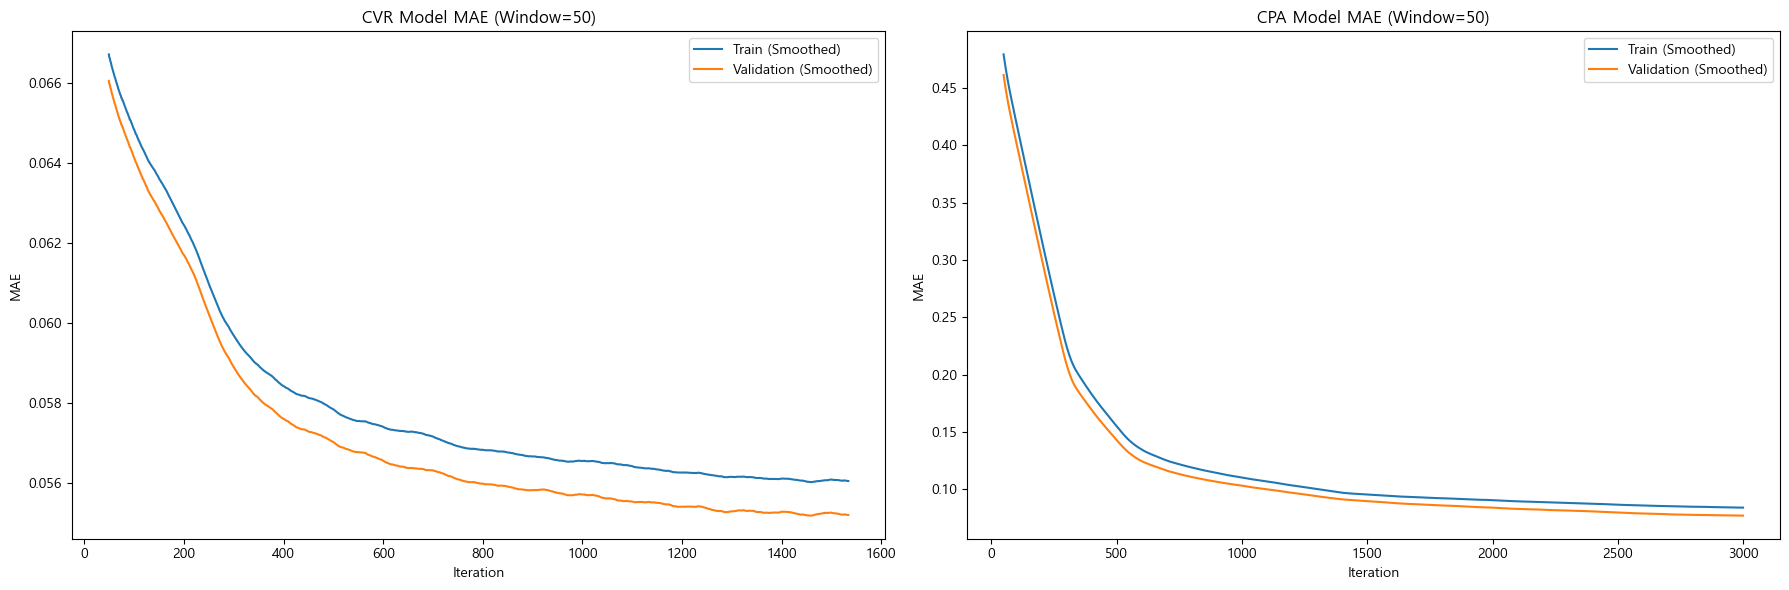

In [60]:
# CVR, CPA MAE 평가
res_cvr = results_0['CVR'].get_evals_result()
res_cpa = results_0['CPA'].get_evals_result()

window_size = 50
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# CVR Train/ Validation
train_mae_cvr = pd.Series(res_cvr['learn']['MAE'])
val_mae_cvr = pd.Series(res_cvr['validation']['MAE'])

axes[0].plot(train_mae_cvr.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[0].plot(val_mae_cvr.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MAE')
axes[0].set_title(f'CVR Model MAE (Window={window_size})')
axes[0].legend()

# CPA Train/ Validation
train_mae_cpa = pd.Series(res_cpa['learn']['MAE'])
val_mae_cpa = pd.Series(res_cpa['validation']['MAE'])

axes[1].plot(train_mae_cpa.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[1].plot(val_mae_cpa.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('MAE')
axes[1].set_title(f'CPA Model MAE (Window={window_size})')
axes[1].legend()

plt.tight_layout()
plt.show()

In [61]:
unique_conditions = ive_cluster_0[['ads_shape', 'mda_idx', 'ads_time']].drop_duplicates()

# CVR, CPA Regression
pred_cvr_log = results_0['CVR'].predict(unique_conditions)
pred_cvr = np.expm1(pred_cvr_log)

pred_cpa_log = results_0['CPA'].predict(unique_conditions)
pred_cpa = np.expm1(pred_cpa_log)

# result_df 데이터 정리
result_df = unique_conditions.copy()
result_df['Pred_CVR'] = pred_cvr
result_df['Pred_CPA'] = pred_cpa
result_df['mda_idx'] = result_df['mda_idx'].astype(str)

# 신뢰할 수 있는 데이터셋 추출 : Data_count >= 20
count_df = ive_cluster_0.groupby(['ads_shape', 'mda_idx', 'ads_time']).size().reset_index(name='Data_Count')
count_df['mda_idx'] = count_df['mda_idx'].astype(str)
result_df = pd.merge(
    result_df,
    count_df,
    on=['ads_shape', 'mda_idx', 'ads_time'],
    how='left'
)
result_df['Data_Count'] = result_df['Data_Count'].fillna(0)
result_df = result_df[result_df['Data_Count'] >= 20].copy()

# 스케일링
scaler = RobustScaler()
scaled_vals = scaler.fit_transform(result_df[['Pred_CVR', 'Pred_CPA']])
result_df['CVR_scaled'] = scaled_vals[:, 0]
result_df['CPA_scaled'] = scaled_vals[:, 1]

# 효율 점수 측정
result_df['score'] = result_df['CVR_scaled'] + (1 - result_df['CPA_scaled'])

# Top 10 정리
top_0 = result_df.sort_values('score', ascending=False).head(10).copy()
top_0['Rank'] = [1,2,3,4,5,6,7,8,9,10]

pd.options.display.float_format = '{:.4f}'.format
print('\n=== 신뢰할 수 있는 예측 Top 10 (점수 기준) ===')
print(top_0[['ads_shape', 'mda_idx', 'ads_time','CVR_scaled', 'CPA_scaled', 'score', 'Data_Count']])


=== 신뢰할 수 있는 예측 Top 10 (점수 기준) ===
     ads_shape mda_idx       ads_time  CVR_scaled  CPA_scaled   score  \
476         퀴즈     563  Early Morning     39.3696     -0.3161 40.6858   
1107   단순 앱 활동     563  Early Morning     37.2744     -0.3138 38.5882   
518         퀴즈     634  Early Morning     37.0481     -0.3200 38.3681   
48          퀴즈     563        Evening     36.6153     -0.3160 37.9313   
705     설치/ 실행     303      Afternoon     35.8815     -0.0012 36.8827   
706     설치/ 실행     324      Afternoon     35.8815     -0.0007 36.8822   
837     설치/ 실행     341      Afternoon     35.8815     -0.0004 36.8819   
707     설치/ 실행     340      Afternoon     35.8815      0.0020 36.8795   
266     URL 입력     371      Afternoon     32.7354     -0.3187 34.0541   
127         퀴즈     371      Afternoon     32.4475     -0.3160 33.7635   

      Data_Count  
476          437  
1107          56  
518           53  
48           135  
705         1447  
706         1539  
837         1560  
707     

#### b. Cluster 1

In [62]:
# CVR 회귀
targets = ['CVR']
features = ['ads_shape', 'mda_idx', 'ads_time']
cat_features = ['ads_shape', 'mda_idx', 'ads_time']

results_1 = {}

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    X = ive_cluster_1[features]
    y = ive_cluster_1[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cvr = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.01,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        early_stopping_rounds=100,
        metric_period=1,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cvr.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_1[target] = model_cvr

    # 모델 평가
    y_pred_log = model_cvr.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.2105867	test: 0.2096789	best: 0.2096789 (0)	total: 6.53ms	remaining: 19.6s
200:	learn: 0.1393627	test: 0.1385366	best: 0.1385366 (200)	total: 4.96s	remaining: 1m 9s
400:	learn: 0.1328257	test: 0.1320986	best: 0.1320986 (400)	total: 9.75s	remaining: 1m 3s
600:	learn: 0.1307718	test: 0.1301393	best: 0.1301221 (596)	total: 14.3s	remaining: 57s
800:	learn: 0.1296149	test: 0.1291315	best: 0.1291315 (800)	total: 18.8s	remaining: 51.7s
1000:	learn: 0.1290295	test: 0.1284580	best: 0.1283193 (995)	total: 23.4s	remaining: 46.8s
1200:	learn: 0.1283050	test: 0.1278086	best: 0.1277739 (1178)	total: 28s	remaining: 41.9s
1400:	learn: 0.1279244	test: 0.1275686	best: 0.1274525 (1395)	total: 32.5s	remaining: 37.1s
1600:	learn: 0.1276056	test: 0.1272002	best: 0.1270216 (1579)	total: 37.1s	remaining: 32.4s
1800:	learn: 0.1273684	test: 0.1270394	best: 0.1267904 (1774)	total: 41.7s	remaining: 27.7s
2000:	learn: 0.1270086	test: 0.1

In [63]:
# CPA 회귀
targets = ['CPA']
features = ['ads_shape', 'mda_idx', 'ads_time']
cat_features = ['ads_shape', 'mda_idx', 'ads_time']

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    valid_cpa_df = ive_cluster_1[ive_cluster_1['CVR'] > 0].copy()

    X = valid_cpa_df[features]
    y = valid_cpa_df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cpa = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.01,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        metric_period=1,
        early_stopping_rounds=100,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cpa.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_1[target] = model_cpa

    # 모델 평가
    y_pred_log = model_cpa.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.8229854	test: 0.8248685	best: 0.8248685 (0)	total: 22.8ms	remaining: 1m 8s
200:	learn: 0.4818657	test: 0.4809144	best: 0.4809144 (200)	total: 4.11s	remaining: 57.3s
400:	learn: 0.2192900	test: 0.2172178	best: 0.2172178 (400)	total: 8.1s	remaining: 52.5s
600:	learn: 0.1576534	test: 0.1553561	best: 0.1553062 (599)	total: 12s	remaining: 48s
800:	learn: 0.1509159	test: 0.1487373	best: 0.1487003 (799)	total: 16s	remaining: 44s
1000:	learn: 0.1474307	test: 0.1453284	best: 0.1452622 (998)	total: 20s	remaining: 39.9s
1200:	learn: 0.1457013	test: 0.1436336	best: 0.1436336 (1200)	total: 23.9s	remaining: 35.8s
1400:	learn: 0.1446223	test: 0.1426027	best: 0.1426014 (1398)	total: 27.9s	remaining: 31.8s
1600:	learn: 0.1437275	test: 0.1418442	best: 0.1417922 (1588)	total: 31.8s	remaining: 27.8s
1800:	learn: 0.1429523	test: 0.1411291	best: 0.1410276 (1799)	total: 35.8s	remaining: 23.8s
2000:	learn: 0.1422269	test: 0.1404383	

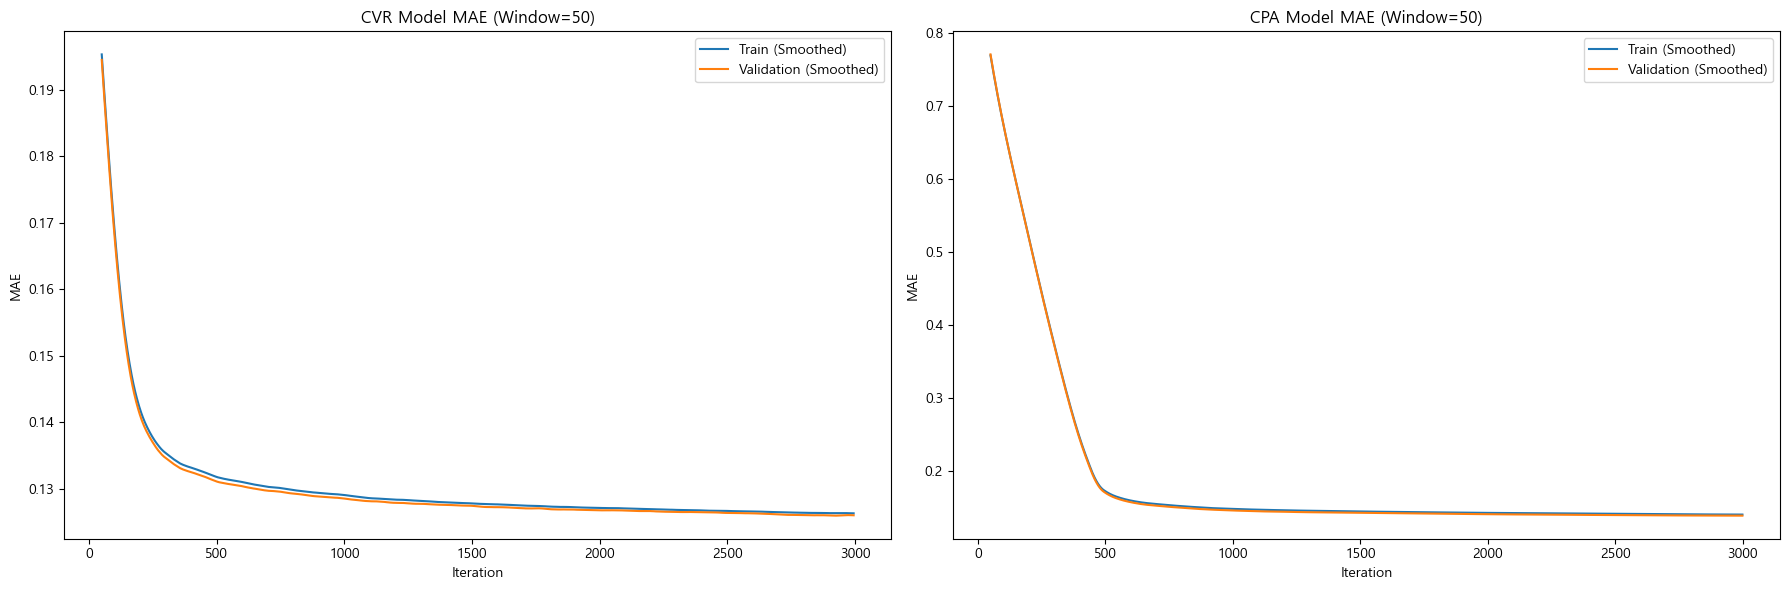

In [64]:
# CVR, CPA MAE 평가
res_cvr = results_1['CVR'].get_evals_result()
res_cpa = results_1['CPA'].get_evals_result()

window_size = 50
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# CVR Train/ Validation
train_mae_cvr = pd.Series(res_cvr['learn']['MAE'])
val_mae_cvr = pd.Series(res_cvr['validation']['MAE'])

axes[0].plot(train_mae_cvr.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[0].plot(val_mae_cvr.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MAE')
axes[0].set_title(f'CVR Model MAE (Window={window_size})')
axes[0].legend()

# CPA Train/ Validation
train_mae_cpa = pd.Series(res_cpa['learn']['MAE'])
val_mae_cpa = pd.Series(res_cpa['validation']['MAE'])

axes[1].plot(train_mae_cpa.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[1].plot(val_mae_cpa.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('MAE')
axes[1].set_title(f'CPA Model MAE (Window={window_size})')
axes[1].legend()

plt.tight_layout()
plt.show()

In [65]:
unique_conditions = ive_cluster_1[['ads_shape', 'mda_idx', 'ads_time']].drop_duplicates()

# CVR, CPA Regression
pred_cvr_log = results_1['CVR'].predict(unique_conditions)
pred_cvr = np.expm1(pred_cvr_log)

pred_cpa_log = results_1['CPA'].predict(unique_conditions)
pred_cpa = np.expm1(pred_cpa_log)

# result_df 데이터 정리
result_df = unique_conditions.copy()
result_df['Pred_CVR'] = pred_cvr
result_df['Pred_CPA'] = pred_cpa
result_df['mda_idx'] = result_df['mda_idx'].astype(str)

# 신뢰할 수 있는 데이터셋 추출 : Data_count >= 20
count_df = ive_cluster_1.groupby(['ads_shape', 'mda_idx', 'ads_time']).size().reset_index(name='Data_Count')
count_df['mda_idx'] = count_df['mda_idx'].astype(str)
result_df = pd.merge(
    result_df,
    count_df,
    on=['ads_shape', 'mda_idx', 'ads_time'],
    how='left'
)
result_df['Data_Count'] = result_df['Data_Count'].fillna(0)
result_df = result_df[result_df['Data_Count'] >= 20].copy()

# 스케일링
scaler = RobustScaler()
scaled_vals = scaler.fit_transform(result_df[['Pred_CVR', 'Pred_CPA']])
result_df['CVR_scaled'] = scaled_vals[:, 0]
result_df['CPA_scaled'] = scaled_vals[:, 1]

# 효율 점수 측정
result_df['score'] = result_df['CVR_scaled'] + (1 - result_df['CPA_scaled'])

# Top 10 정리
top_1 = result_df.sort_values('score', ascending=False).head(10).copy()
top_1['Rank'] = [1,2,3,4,5,6,7,8,9,10]

pd.options.display.float_format = '{:.4f}'.format
print('\n=== 신뢰할 수 있는 예측 Top 10 (점수 기준) ===')
print(top_1[['ads_shape', 'mda_idx', 'ads_time','CVR_scaled', 'CPA_scaled', 'score', 'Data_Count']])


=== 신뢰할 수 있는 예측 Top 10 (점수 기준) ===
     ads_shape mda_idx       ads_time  CVR_scaled  CPA_scaled  score  \
731     URL 입력     413  Early Morning      1.9600     -0.2323 3.1923   
1712   단순 앱 활동     994        Morning      1.9396     -0.2411 3.1807   
1636   단순 앱 활동    1001        Morning      1.9396     -0.2411 3.1807   
1771   단순 앱 활동     993        Morning      1.9396     -0.2411 3.1807   
1639   단순 앱 활동    1013        Morning      1.9388     -0.2411 3.1800   
90          퀴즈     413        Evening      1.9450     -0.2323 3.1773   
92          퀴즈      28        Evening      1.9437     -0.2302 3.1738   
638    단순 앱 활동     711        Morning      1.9417     -0.2321 3.1738   
626    단순 앱 활동     246        Morning      1.9414     -0.2301 3.1716   
68          퀴즈     413        Morning      1.9277     -0.2334 3.1611   

      Data_Count  
731           25  
1712         175  
1636          67  
1771          77  
1639         199  
90            78  
92            26  
638           61  


#### c. Cluster 2

In [66]:
# CVR 회귀
targets = ['CVR']
features = ['ads_shape', 'mda_idx', 'ads_time']
cat_features = ['ads_shape', 'mda_idx', 'ads_time']

results_2 = {}

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    X = ive_cluster_2[features]
    y = ive_cluster_2[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cvr = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.05,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        early_stopping_rounds=100,
        metric_period=1,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cvr.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_2[target] = model_cvr

    # 모델 평가
    y_pred_log = model_cvr.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.2513605	test: 0.2511503	best: 0.2511503 (0)	total: 41.8ms	remaining: 2m 5s
200:	learn: 0.1851579	test: 0.1849004	best: 0.1846376 (172)	total: 8.73s	remaining: 2m 1s
400:	learn: 0.1845550	test: 0.1844213	best: 0.1842054 (371)	total: 17s	remaining: 1m 50s
600:	learn: 0.1840190	test: 0.1838157	best: 0.1837719 (597)	total: 25.4s	remaining: 1m 41s
800:	learn: 0.1835499	test: 0.1833327	best: 0.1833327 (800)	total: 33.6s	remaining: 1m 32s
1000:	learn: 0.1833447	test: 0.1831265	best: 0.1830990 (963)	total: 41.9s	remaining: 1m 23s
1200:	learn: 0.1832313	test: 0.1830011	best: 0.1828717 (1110)	total: 50.2s	remaining: 1m 15s
bestTest = 0.1828716707
bestIteration = 1110
Shrink model to first 1111 iterations.
CVR    |    0.2699


In [67]:
# CPA 회귀
targets = ['CPA']
features = ['ads_shape', 'mda_idx', 'ads_time']
cat_features = ['ads_shape', 'mda_idx', 'ads_time']

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    valid_cpa_df = ive_cluster_2[ive_cluster_2['CVR'] > 0].copy()

    X = valid_cpa_df[features]
    y = valid_cpa_df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cpa = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.05,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        metric_period=1,
        early_stopping_rounds=100,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cpa.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_2[target] = model_cpa

    # 모델 평가
    y_pred_log = model_cpa.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.6343049	test: 0.6314093	best: 0.6314093 (0)	total: 35.6ms	remaining: 1m 46s
200:	learn: 0.1155742	test: 0.1145097	best: 0.1141408 (197)	total: 6.98s	remaining: 1m 37s
400:	learn: 0.1103290	test: 0.1095655	best: 0.1086748 (357)	total: 13.5s	remaining: 1m 27s
600:	learn: 0.1084154	test: 0.1077567	best: 0.1071086 (509)	total: 19.6s	remaining: 1m 18s
bestTest = 0.1071085894
bestIteration = 509
Shrink model to first 510 iterations.
CPA    |   69.6655


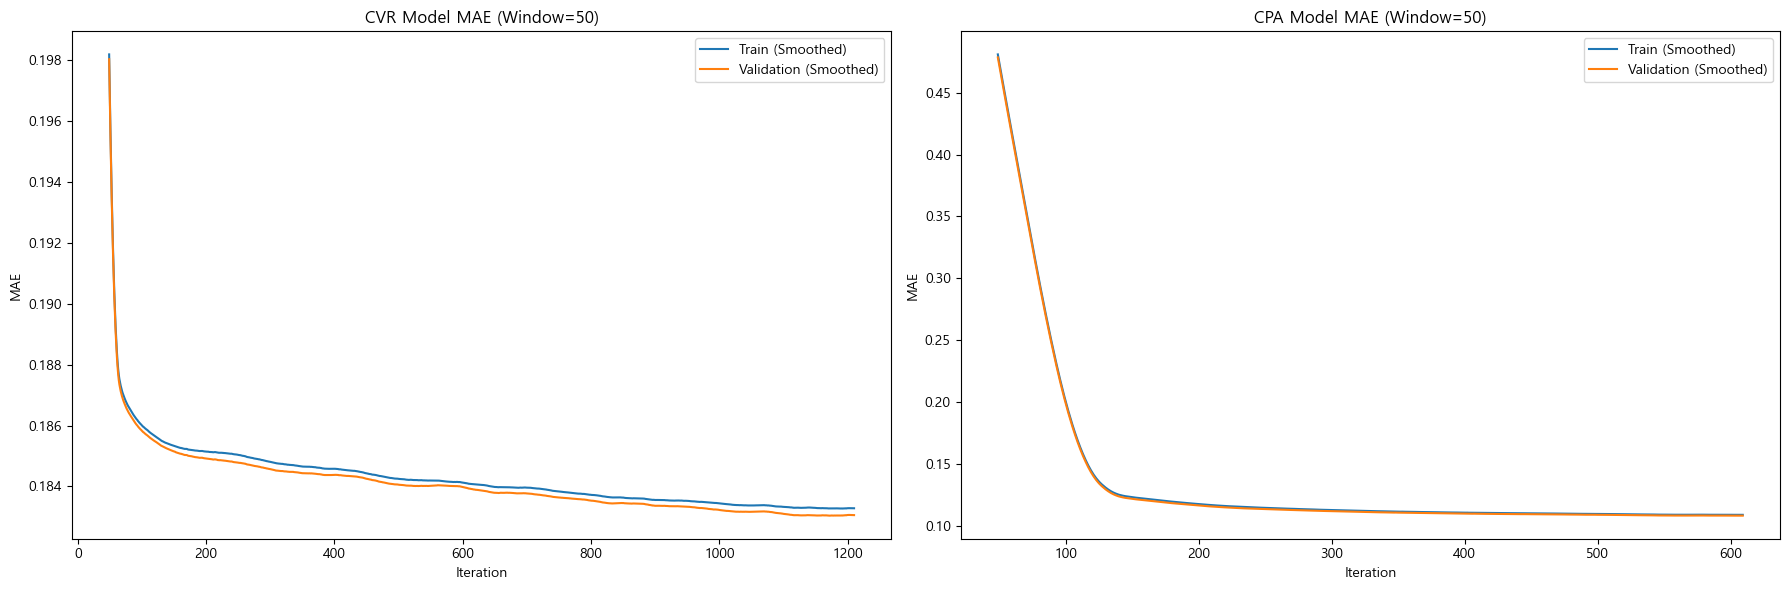

In [68]:
# CVR, CPA MAE 평가
res_cvr = results_2['CVR'].get_evals_result()
res_cpa = results_2['CPA'].get_evals_result()

window_size = 50
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# CVR Train/ Validation
train_mae_cvr = pd.Series(res_cvr['learn']['MAE'])
val_mae_cvr = pd.Series(res_cvr['validation']['MAE'])

axes[0].plot(train_mae_cvr.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[0].plot(val_mae_cvr.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MAE')
axes[0].set_title(f'CVR Model MAE (Window={window_size})')
axes[0].legend()

# CPA Train/ Validation
train_mae_cpa = pd.Series(res_cpa['learn']['MAE'])
val_mae_cpa = pd.Series(res_cpa['validation']['MAE'])

axes[1].plot(train_mae_cpa.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[1].plot(val_mae_cpa.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('MAE')
axes[1].set_title(f'CPA Model MAE (Window={window_size})')
axes[1].legend()

plt.tight_layout()
plt.show()

In [69]:
unique_conditions = ive_cluster_2[['ads_shape', 'mda_idx', 'ads_time']].drop_duplicates()

# CVR, CPA Regression
pred_cvr_log = results_2['CVR'].predict(unique_conditions)
pred_cvr = np.expm1(pred_cvr_log)

pred_cpa_log = results_2['CPA'].predict(unique_conditions)
pred_cpa = np.expm1(pred_cpa_log)

# result_df 데이터 정리
result_df = unique_conditions.copy()
result_df['Pred_CVR'] = pred_cvr
result_df['Pred_CPA'] = pred_cpa
result_df['mda_idx'] = result_df['mda_idx'].astype(str)

# 신뢰할 수 있는 데이터셋 추출 : Data_count >= 20
count_df = ive_cluster_2.groupby(['ads_shape', 'mda_idx', 'ads_time']).size().reset_index(name='Data_Count')
count_df['mda_idx'] = count_df['mda_idx'].astype(str)
result_df = pd.merge(
    result_df,
    count_df,
    on=['ads_shape', 'mda_idx', 'ads_time'],
    how='left'
)
result_df['Data_Count'] = result_df['Data_Count'].fillna(0)
result_df = result_df[result_df['Data_Count'] >= 20].copy()

# 스케일링
scaler = RobustScaler()
scaled_vals = scaler.fit_transform(result_df[['Pred_CVR', 'Pred_CPA']])
result_df['CVR_scaled'] = scaled_vals[:, 0]
result_df['CPA_scaled'] = scaled_vals[:, 1]

# 효율 점수 측정
result_df['score'] = result_df['CVR_scaled'] + (1 - result_df['CPA_scaled'])

# Top 10 정리
top_2 = result_df.sort_values('score', ascending=False).head(10).copy()
top_2['Rank'] = [1,2,3,4,5,6,7,8,9,10]

pd.options.display.float_format = '{:.4f}'.format
print('\n=== 신뢰할 수 있는 예측 Top 10 (점수 기준) ===')
print(top_2[['ads_shape', 'mda_idx', 'ads_time','CVR_scaled', 'CPA_scaled', 'score', 'Data_Count']])


=== 신뢰할 수 있는 예측 Top 10 (점수 기준) ===
          ads_shape mda_idx       ads_time  CVR_scaled  CPA_scaled  score  \
941          URL 입력     492        Morning      0.9741     -1.0578 3.0319   
920          URL 입력     568        Morning      0.9142     -1.0578 2.9720   
1023         설치/ 실행     817  Early Morning      0.7306     -1.1477 2.8783   
2763         설치/ 실행    1061  Early Morning      0.7305     -1.1477 2.8782   
677   퀘스트/ 스테이지 클리어      28  Early Morning      0.8238     -1.0441 2.8678   
2614         설치/ 실행     818  Early Morning      0.7091     -1.1477 2.8568   
956          설치/ 실행     270  Early Morning      0.7040     -1.1483 2.8522   
1401        개인정보 제공     413  Early Morning      0.7552     -1.0933 2.8486   
824              퀴즈     212        Evening      0.8004     -1.0433 2.8437   
980          설치/ 실행     389  Early Morning      0.7197     -1.1226 2.8423   

      Data_Count  
941           74  
920           37  
1023         625  
2763         106  
677           25  
26

#### d. Cluster 3

In [70]:
# CVR 회귀
targets = ['CVR']
features = ['ads_shape', 'mda_idx', 'ads_time']
cat_features = ['ads_shape', 'mda_idx', 'ads_time']

results_3 = {}

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    X = ive_cluster_3[features]
    y = ive_cluster_3[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cvr = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.01,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        early_stopping_rounds=100,
        metric_period=1,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cvr.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_3[target] = model_cvr

    # 모델 평가
    y_pred_log = model_cvr.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.1898795	test: 0.1896963	best: 0.1896963 (0)	total: 32ms	remaining: 1m 35s
200:	learn: 0.1604529	test: 0.1601112	best: 0.1600973 (191)	total: 6.18s	remaining: 1m 26s
400:	learn: 0.1598923	test: 0.1595307	best: 0.1594819 (399)	total: 12.2s	remaining: 1m 18s
600:	learn: 0.1596306	test: 0.1592775	best: 0.1592677 (598)	total: 18.1s	remaining: 1m 12s
800:	learn: 0.1595131	test: 0.1591888	best: 0.1591344 (795)	total: 23.9s	remaining: 1m 5s
1000:	learn: 0.1593696	test: 0.1590108	best: 0.1589924 (987)	total: 29.8s	remaining: 59.5s
1200:	learn: 0.1592568	test: 0.1589396	best: 0.1589370 (1123)	total: 35.6s	remaining: 53.4s
1400:	learn: 0.1592623	test: 0.1589270	best: 0.1588145 (1387)	total: 41.5s	remaining: 47.4s
bestTest = 0.1588145178
bestIteration = 1387
Shrink model to first 1388 iterations.
CVR    |    0.2468


In [71]:
# CPA 회귀
targets = ['CPA']
features = ['ads_shape', 'mda_idx', 'ads_time']
cat_features = ['ads_shape', 'mda_idx', 'ads_time']

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    valid_cpa_df = ive_cluster_3[ive_cluster_3['CVR'] > 0].copy()

    X = valid_cpa_df[features]
    y = valid_cpa_df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cpa = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.01,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        metric_period=1,
        early_stopping_rounds=100,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cpa.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_3[target] = model_cpa

    # 모델 평가
    y_pred_log = model_cpa.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.1529124	test: 0.1532893	best: 0.1532893 (0)	total: 26.7ms	remaining: 1m 19s
200:	learn: 0.0962468	test: 0.0964912	best: 0.0964912 (200)	total: 5.56s	remaining: 1m 17s
400:	learn: 0.0885000	test: 0.0886286	best: 0.0886286 (400)	total: 10.9s	remaining: 1m 10s
600:	learn: 0.0850126	test: 0.0849789	best: 0.0849391 (598)	total: 16.2s	remaining: 1m 4s
800:	learn: 0.0831844	test: 0.0830907	best: 0.0829848 (799)	total: 21.4s	remaining: 58.9s
1000:	learn: 0.0824585	test: 0.0822895	best: 0.0822895 (1000)	total: 26.7s	remaining: 53.4s
1200:	learn: 0.0823799	test: 0.0821941	best: 0.0819436 (1194)	total: 32.1s	remaining: 48.1s
bestTest = 0.08183469834
bestIteration = 1225
Shrink model to first 1226 iterations.
CPA    |    6.0684


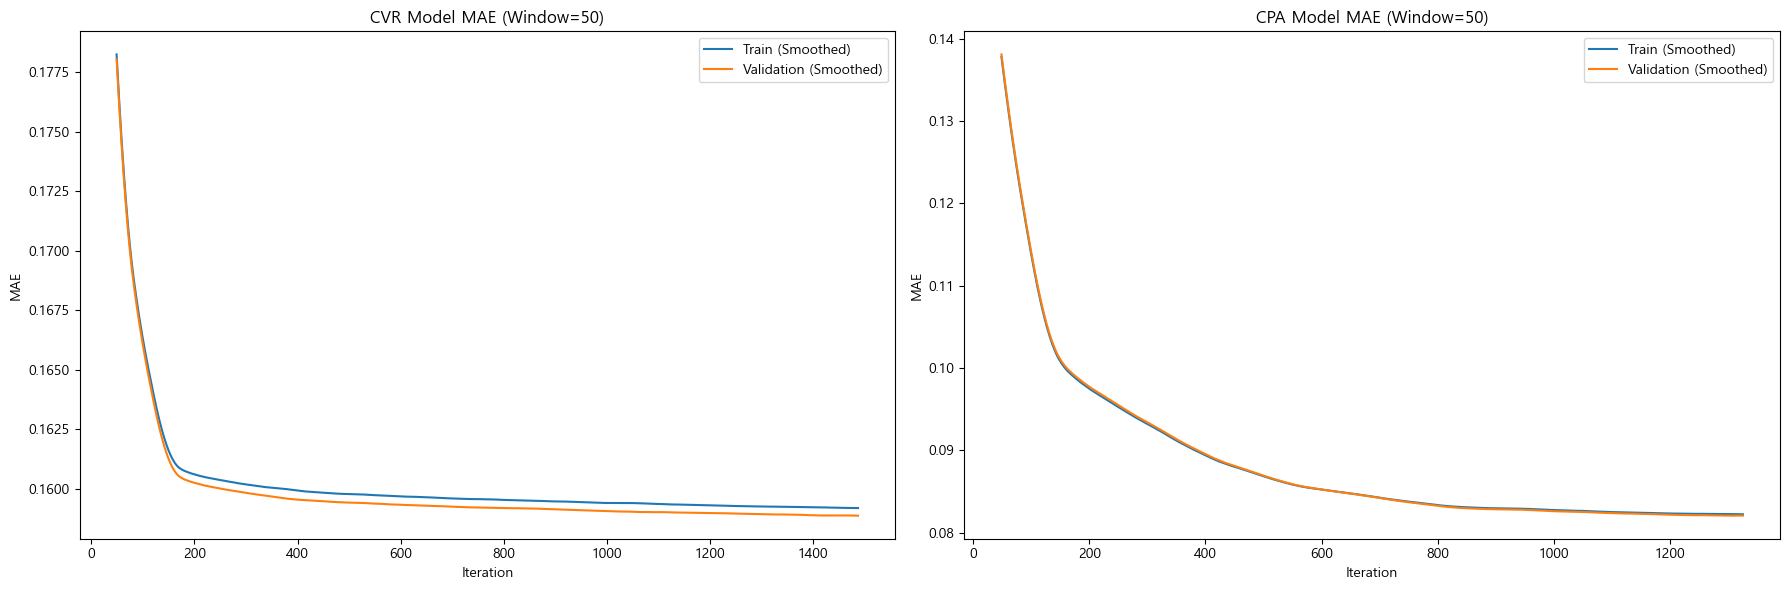

In [72]:
# CVR, CPA MAE 평가
res_cvr = results_3['CVR'].get_evals_result()
res_cpa = results_3['CPA'].get_evals_result()

window_size = 50
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# CVR Train/ Validation
train_mae_cvr = pd.Series(res_cvr['learn']['MAE'])
val_mae_cvr = pd.Series(res_cvr['validation']['MAE'])

axes[0].plot(train_mae_cvr.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[0].plot(val_mae_cvr.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MAE')
axes[0].set_title(f'CVR Model MAE (Window={window_size})')
axes[0].legend()

# CPA Train/ Validation
train_mae_cpa = pd.Series(res_cpa['learn']['MAE'])
val_mae_cpa = pd.Series(res_cpa['validation']['MAE'])

axes[1].plot(train_mae_cpa.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[1].plot(val_mae_cpa.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('MAE')
axes[1].set_title(f'CPA Model MAE (Window={window_size})')
axes[1].legend()

plt.tight_layout()
plt.show()

In [73]:
unique_conditions = ive_cluster_3[['ads_shape', 'mda_idx', 'ads_time']].drop_duplicates()

# CVR, CPA Regression
pred_cvr_log = results_3['CVR'].predict(unique_conditions)
pred_cvr = np.expm1(pred_cvr_log)

pred_cpa_log = results_3['CPA'].predict(unique_conditions)
pred_cpa = np.expm1(pred_cpa_log)

# result_df 데이터 정리
result_df = unique_conditions.copy()
result_df['Pred_CVR'] = pred_cvr
result_df['Pred_CPA'] = pred_cpa
result_df['mda_idx'] = result_df['mda_idx'].astype(str)

# 신뢰할 수 있는 데이터셋 추출 : Data_count >= 20
count_df = ive_cluster_3.groupby(['ads_shape', 'mda_idx', 'ads_time']).size().reset_index(name='Data_Count')
count_df['mda_idx'] = count_df['mda_idx'].astype(str)
result_df = pd.merge(
    result_df,
    count_df,
    on=['ads_shape', 'mda_idx', 'ads_time'],
    how='left'
)
result_df['Data_Count'] = result_df['Data_Count'].fillna(0)
result_df = result_df[result_df['Data_Count'] >= 20].copy()

# 스케일링
scaler = RobustScaler()
scaled_vals = scaler.fit_transform(result_df[['Pred_CVR', 'Pred_CPA']])
result_df['CVR_scaled'] = scaled_vals[:, 0]
result_df['CPA_scaled'] = scaled_vals[:, 1]

# 효율 점수 측정
result_df['score'] = result_df['CVR_scaled'] + (1 - result_df['CPA_scaled'])

# Top 10 정리
top_3 = result_df.sort_values('score', ascending=False).head(10).copy()
top_3['Rank'] = [1,2,3,4,5,6,7,8,9,10]

pd.options.display.float_format = '{:.4f}'.format
print('\n=== 신뢰할 수 있는 예측 Top 10 (점수 기준) ===')
print(top_3[['ads_shape', 'mda_idx', 'ads_time','CVR_scaled', 'CPA_scaled', 'score', 'Data_Count']])


=== 신뢰할 수 있는 예측 Top 10 (점수 기준) ===
    ads_shape mda_idx       ads_time  CVR_scaled  CPA_scaled  score  \
28         퀴즈     413        Morning      0.7720     -0.7727 2.5448   
31         퀴즈     568        Morning      0.7719     -0.7716 2.5435   
25         퀴즈     389        Morning      0.7717     -0.7712 2.5429   
183        퀴즈     492        Morning      0.7680     -0.7680 2.5360   
546    URL 입력     270  Early Morning      0.8030     -0.7243 2.5273   
194        퀴즈     482        Morning      0.7694     -0.7510 2.5203   
29         퀴즈     212        Morning      0.7794     -0.7118 2.4912   
54         퀴즈     634        Morning      0.7682     -0.7202 2.4884   
455    URL 입력     371  Early Morning      0.7706     -0.7154 2.4861   
425    URL 입력      54  Early Morning      0.7687     -0.7154 2.4841   

     Data_Count  
28         6117  
31         6264  
25         3668  
183        1756  
546          56  
194         347  
29         2904  
54         6598  
455         530  
42

#### e. 군집별 Top 10 데이터 추출
- Top 10 데이터 저장 (for. Tableau)
- results 모델 데이터 저장 (for. Streamlit)

In [75]:
# top 데이터마다 Cluster 칼럼 추가
top_0['Cluster'] = 0
top_1['Cluster'] = 1
top_2['Cluster'] = 2
top_3['Cluster'] = 3

# 세로 병합
top_total = pd.concat([top_0, top_1, top_2, top_3])

# ive_top_10.csv 저장
top_total.to_csv(os.path.join(folder_tableau, 'ive_top_10.csv'))

# results_0, results_1, results_2, results_3 모델 pkl 저장
for i in range(0, 4):
    file_path = os.path.join('model', f'ive_model_cluster_{i}.pkl')
    
    if f'results_{i}' in globals():
        actual_model = globals()[f'results_{i}']
        with open(file_path, 'wb') as f:
            pickle.dump(actual_model, f)
    else:
        print(f'경고: results_{i} 변수를 찾을 수 없습니다.')